In [96]:
from webtoon_dataset import WebtoonDataset
from webtoon_model import DescriptionClassifier
from webtoon_dataloader import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

webtoon= pd.read_csv('./data/naver.csv')[['title', 'genre', 'description']]
print(webtoon.shape)
webtoon.head(10)

(1856, 3)


,title,genre,description
0,가난을 등에 업은 소녀,"스토리, 로맨스",흔하디 흔한 재벌후계자와 캔디도 울고 갈 박복한 가난소녀의 파란만장 동거기!인기작 ...
1,가담항설,"스토리, 판타지",이번 주인공은 돌이다!돌이지만 동료도 모으고 악당도 물리친다!랑또 작가표 동양 판타...
2,가령의 정체불명 이야기,"옴니버스, 드라마",어느 날... 인어가 내게 말을 걸어왔다. 눈을 떠보니 총구가 있었다. 그리고 몸이...
3,가비지타임,"스토리, 스포츠","한국 최초 한국형 고교스포츠 웹툰!열혈따윈 개나 줘, 낙오자들 뿐인 농구부의 운명은?"
4,가상&RPG,"스토리, 판타지","""사람은 좀 죽여도 싸우는건 싫어해요."" 게임에서조차 집 바깥을 나가지 않는 '제리..."
5,가슴털 로망스,"스토리, 개그",최고의 상남자가 되기 위한 여행을 떠나는 장호풍과 친구들명언범벅 눈물범벅 의리범벅 ...
6,가우스전자 시즌1~2,"스토리, 개그",다국적 문어발 기업 가우스전자 마케팅3부 이야기\r\n<트라우마> 곽백수 작가가 선...
7,가우스전자 시즌3~4,"에피소드, 개그",다국적 문어발 기업 가우스전자에서 벌어지는웃픈 현실 직장인 이야기
8,가족같은 XX,"스토리, 로맨스",탑 배우 한나나는 우연히 갈 곳 없는 고등학생 유성우를 집에 들인다.아슬아슬한 동거...
9,가족의 초상,"에피소드, 드라마","할머니의 죽음과 그로 인한 가족들의 변화를 겪어 나가면서, 당연하게만 생각했던 가족..."


In [97]:
webtoon['genre'].apply(lambda s : s.split()[-1])

0       로맨스
1       판타지
2       드라마
3       스포츠
4       판타지
       ... 
1851    로맨스
1852     개그
1853    드라마
1854    로맨스
1855    스릴러
Name: genre, Length: 1856, dtype: object

In [98]:
webtoon['description'].apply(text_preprocess_re)

0       흔하디 흔한 재벌후계자와 캔디도 울고 갈 박복한 가난소녀의 파란만장 동거기  인기작...
1       이번 주인공은 돌이다  돌이지만 동료도 모으고 악당도 물리친다  랑또 작가표 동양 ...
2       어느 날       인어가 내게 말을 걸어왔다   눈을 떠보니 총구가 있었다   그...
3       한국 최초 한국형 고교스포츠 웹툰  열혈따윈 개나 줘   낙오자들 뿐인 농구부의 운...
4        사람은 좀 죽여도 싸우는건 싫어해요   게임에서조차 집 바깥을 나가지 않는  '제...
                              ...                        
1851     넌 내가 나비라는걸 알고 있잖아  알면서도 빠지고 싶은 사랑 투명한 동거  정서 ...
1852     고객은 왕이 아니다   직원이 왕이다  병맛 드라마를 뛰어넘는 미친 상상력의 원작 웹툰
1853    결혼  년차 부부   성대광과 유선영   대학시절 킹카 퀸카로 CC로 만나 결혼까지...
1854    못생긴 얼굴에서 미인으로 새롭게 태어난 그녀   강미래   그런데       어디서...
1855    평범하던 학교에 벌어진 감금사건    그리고 감금사건에 가려 미처 알지 못한 감염자...
Name: description, Length: 1856, dtype: object

In [99]:
from argparse import Namespace

args = Namespace(
    # 경로 정보
    frequency_cutoff = 25,
    model_state_file = './model.pth',
    webtoon_csv1 = './data/naver.csv',
    webtoon_csv2 = '',
    save_dir = './model_storage/ch3/yelp/',
    vectorizer_file = 'vectorizer.json',
    
    # 모델 하이퍼 파라미터
    fc1_dim1 = 128,
    fc1_dim2 = 256,
    
    # 모델 훈련 하이퍼 파라미터
    batch_size = 128,
    early_stopoping_criteria = 5,
    learning_rate = 0.0001,
    num_epochs = 100,
    seed = 493   
)

In [100]:
import torch.optim as optim
def  make_train_state(args):
    return{'epoch_index': 0,
           'train_loss':[],
           'train_acc':[],
           'val_loss':[],
           'val_acc':[],
           'test_loss':-1,
           'test_acc':-1
          }
train_state = make_train_state(args)

In [101]:
train_state

{'epoch_index': 0,
 'train_loss': [],
 'train_acc': [],
 'val_loss': [],
 'val_acc': [],
 'test_loss': -1,
 'test_acc': -1}

In [102]:
import torch
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device('cuda' if args.cuda else 'cpu')

In [103]:
# 데이터 셋과 vectorizer
dataset = WebtoonDataset.load_dataset_and_make_vectorizer(args.webtoon_csv1,args.webtoon_csv2)
vectorizer = dataset.get_vectorizer()

In [104]:
dataset.get_target_df()

,title,genre,description
1516,택배 왔습니다,thrill,선호 풍족하진 않지만 소소한 행복 즐기며 살아가는 평범한 택배 평소 배달 하던 배달...
1293,잉여특공대,fantasy,뽀짝 특공대 원 슈퍼히어로 스
1159,왕으로 살다,historical,살해 쌍둥이 오빠 대신 해 왕 자리 오른 화현 운명
1062,역전! 야매요리,comic,했으니 실패 두렵지 않은 발칙한 요리 도전 포토툰 만나다
565,미치도록 너만을,romance,임시 보호 중인 고양이 찾아 호텔 게스트 하우스 들어가게 인턴 세 희 하필 그룹 이...
...,...,...,...
498,멍순이,pure,산 보이는 샛골 마을 일어나는 꽃님 멍 이의 흙 냄새 풀 냄새
192,꼬맹이를 부탁해!,romance,좋아하는 누나 고백 차인 호연 집 놀러 귀찮은 꼬맹이 누나 동생 고백 하고 애도 돌...
1738,흐드러지다,historical,지배 하는 차지 하려는 암살자 쥬신 황궁 둘러 싼 음모 배신 서서히 드러나는 숨겨진
56,견우와 선녀,drama,죽음 가까워진 거꾸로 걸어 들어 온다 그게 하필 이상형


In [105]:
print(dataset.train_size, dataset.val_size, dataset.test_size)

1044 348 464


In [106]:
dataset.test_df['description']

211                 무작정 떠나고 본다 여행 준비 엉망 진창 낢이 들려주는 네팔 여행기
541     평범한 삶 살려는 특별한 사람과 특별한 찾으려는 평범한 신 삶 행복 관 고려 남녀 ...
1349                             냉혈 광고 홍보 재 조선 시장 성공할 있을까
1218        살아있는 되고 싶은 윈터 베스트셀러 동화 작가 되고 싶은 제인 알록달록 동화 같은
1739    친구 장난 삼아 쓴 피폐 소설 시민 빙의 했다 상급 딸바보 자랑 하는 주인공 아버지...
                              ...                        
1465        지옥 군대 맞서는 항 마승 병 카 루나 카 루나 도전 하는 소년 액션 모험 판타지
542                 지구 멸망했다 달 마음 소리 조석 우주 넘나 드는 판타지 시크 개그
1608                    멸종 위기 처 인간 인간 먹고 사는 괴물 생존 위 전쟁 공생
1043                가장 완벽한 가족 만들어주는 회사 맥코이 하는 하라 친부모 찾고있다
1107                   주변 진짜 큐피드 있다면 믿으시겠어요 큐피드 사랑 만들기 작전
Name: description, Length: 464, dtype: object

In [107]:
dataset.get_vectorizer().genre_vocab.get_token_to_idx()

{'action': 0,
 'comic': 1,
 'daily': 2,
 'drama': 3,
 'fantasy': 4,
 'historical': 5,
 'pure': 6,
 'romance': 7,
 'sports': 8,
 'thrill': 9}

In [108]:
# 모델
classifier = DescriptionClassifier(num_features=len(vectorizer.description_vocab),
                                   hidden_dim1=args.fc1_dim1,
                                   hidden_dim2=args.fc1_dim2,
                                   num_classes =len(vectorizer.genre_vocab))
classifier = classifier.to(args.device)

In [109]:
import torch.nn as nn
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr = args.learning_rate)

In [110]:
# 훈련 반복

for epoch_index in range(args.num_epochs):
    train_state['epoch_index'] = epoch_index
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size,
                                       device = args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):

        # 1. 그래디언트 초기화
        optimizer.zero_grad()

        # 2. 출력 계산
        y_pred = classifier(x_in = batch_dict['x_data'].float())

        # 3. 손실계산
        loss = loss_func(y_pred, batch_dict['y_target'])
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index +1)

        # 4. 그래디언트 계산
        loss.backward()

        # 5. 옵티마이저로 가중치 업데이트
        optimizer.step()

        # 정확도 계산
        acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_batch - running_acc)/ (batch_index +1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    print(f'epoch [{epoch_index:>3d}]')
    print(f'train_loss : {running_loss:>7f}  train_acc : {running_acc:>7f}' )
    
    # 검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
    dataset.set_split('val')
    batch_generator = generate_batches(dataset, 
                                       batch_size= args.batch_size,
                                       device = args.device)
    
    running_loss = 0.0
    running_acc = 0.0
    classifier.eval()
    
    for batch_index, batch_dict in enumerate(batch_generator):
    
        y_pred = classifier(x_in = batch_dict['x_data'].float())

        loss = loss_func(y_pred, batch_dict['y_target'])
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index +1)

        acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_batch - running_acc)/ (batch_index +1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)
    

    print(f'val_loss : {running_loss:>7f}  val_acc : {running_acc:>7f}\n' )
    

epoch [  0]
train_loss : 2.284274  train_acc : 0.131836
val_loss : 2.282053  val_acc : 0.140625

epoch [  1]
train_loss : 2.275524  train_acc : 0.146484
val_loss : 2.269236  val_acc : 0.148438

epoch [  2]
train_loss : 2.265149  train_acc : 0.187500
val_loss : 2.262207  val_acc : 0.187500

epoch [  3]
train_loss : 2.255159  train_acc : 0.211914
val_loss : 2.255345  val_acc : 0.195312

epoch [  4]
train_loss : 2.243982  train_acc : 0.218750
val_loss : 2.243486  val_acc : 0.234375

epoch [  5]
train_loss : 2.231422  train_acc : 0.231445
val_loss : 2.236276  val_acc : 0.222656

epoch [  6]
train_loss : 2.220718  train_acc : 0.234375
val_loss : 2.222512  val_acc : 0.226562

epoch [  7]
train_loss : 2.206673  train_acc : 0.224609
val_loss : 2.215076  val_acc : 0.210938

epoch [  8]
train_loss : 2.191879  train_acc : 0.232422
val_loss : 2.192535  val_acc : 0.226562

epoch [  9]
train_loss : 2.175185  train_acc : 0.228516
val_loss : 2.172400  val_acc : 0.257812

epoch [ 10]
train_loss : 2.156

epoch [ 85]
train_loss : 1.407857  train_acc : 0.523438
val_loss : 1.793025  val_acc : 0.359375

epoch [ 86]
train_loss : 1.409242  train_acc : 0.525391
val_loss : 1.794422  val_acc : 0.367188

epoch [ 87]
train_loss : 1.390095  train_acc : 0.534180
val_loss : 1.796660  val_acc : 0.394531

epoch [ 88]
train_loss : 1.388286  train_acc : 0.541016
val_loss : 1.815409  val_acc : 0.359375

epoch [ 89]
train_loss : 1.390379  train_acc : 0.544922
val_loss : 1.883400  val_acc : 0.355469

epoch [ 90]
train_loss : 1.377805  train_acc : 0.545898
val_loss : 1.820191  val_acc : 0.359375

epoch [ 91]
train_loss : 1.372395  train_acc : 0.536133
val_loss : 1.867185  val_acc : 0.343750

epoch [ 92]
train_loss : 1.360243  train_acc : 0.557617
val_loss : 1.854326  val_acc : 0.351562

epoch [ 93]
train_loss : 1.338398  train_acc : 0.561523
val_loss : 1.830833  val_acc : 0.347656

epoch [ 94]
train_loss : 1.345342  train_acc : 0.544922
val_loss : 1.828647  val_acc : 0.355469

epoch [ 95]
train_loss : 1.338

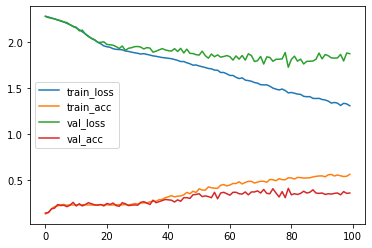

In [111]:
plt.plot(train_state['train_loss'], label = 'train_loss')
plt.plot(train_state['train_acc'], label = 'train_acc')
plt.plot(train_state['val_loss'], label = 'val_loss')
plt.plot(train_state['val_acc'], label = 'val_acc')
plt.legend()
plt.show()

In [112]:
np.array(train_state['val_acc']).argmax()

79

In [113]:

print(f'val_loss :', train_state['val_loss'][11] ,' val_acc', train_state['val_acc'][11])
    

val_loss : 2.1255306005477905  val_acc tensor(0.2422)


### 테스트 데이터로 평가

In [114]:
dataset.set_split('test')
batch_generator = generate_batches(dataset,
                                   batch_size=args.batch_size,
                                   device = args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
#     print(batch_dict['x_data'].float())
    y_pred = classifier(x_in = batch_dict['x_data'].float())
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_batch = loss.item()
    running_loss += (loss_batch - running_loss) / (batch_index +1)

    acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_batch - running_acc)/ (batch_index +1)
    
train_state['test_loss']=(running_loss)
train_state['test_acc']=(running_acc)

print(f'test_loss : {running_loss:>7f}  test_acc : {running_acc:>7f}\n' )

test_loss : 1.743641  test_acc : 0.406250



#### 정규 웹툰 자료만 사용할 경우 
---
##### 은닉층 제외
0. okt (명사 동사 형용사) : 0.385
1. okt.noum : 0.388
2. 정규식 : 0.31

##### 은닉층 포함
0. okt (명사 동사 형용사) : 0.393
1. okt.noum : 0.38
2. 정규식 : 0.31

##### 은닉층( 드랍아웃 많이... ) 
0. okt (명사 동사 형용사) : 0.4036
1. okt.noum : 0.36
2. 정규식 : 0.32
3. okt (명사 동사 형용사) + stopword : 0.37

##### 은닉층( 드랍아웃 많이... )  lr = 0.0001
0. okt (명사 동사 형용사) : 0.406
3. okt (명사 동사 형용사) + stopword : 0.375



In [115]:
import torch
genre_dic = dataset.get_vectorizer().genre_vocab.get_token_to_idx()
def take_preprocess_text(dataset, text):
    text = preprocess_text(text)
    tensor_text = \
        dataset.get_vectorizer().vectorize(text)
    tensor_text = torch.from_numpy(tensor_text)
    return tensor_text

def get_text_predict(dataset, classifier, text):
    classifier.eval()
    pre_text = take_preprocess_text(dataset, text)
    pred = classifier(x_in = pre_text.float())
#     print(pred.detach().numpy().argmax())
    return dataset.get_vectorizer().genre_vocab.lookup_index(pred.detach().numpy().argmax())
#     return 
    

print(genre_dic)
new_test = '마법 이세계 소환 이야기'
get_text_predict(dataset,classifier, new_test)

{'action': 0, 'comic': 1, 'daily': 2, 'drama': 3, 'fantasy': 4, 'historical': 5, 'pure': 6, 'romance': 7, 'sports': 8, 'thrill': 9}


'fantasy'

In [116]:

print(genre_dic,'\n')
new_test = [
    '현실에서는 찐따인 내가 이세계에서는 일류 주방장?',
    '모두가 아는 사내 비밀연애',
    '----- kakao ------',
#     나혼렙
    '''재능 없는 만년 E급 헌터, 성진우.
기이한 던전에서 죽음을 목전에 두지만
위기는 언제나 기회와 함께 찾아오는 법!

[플레이어가 되실 자격을 획득하셨습니다.]
"플레이어? 내가 레벨업을 할 수 있다고?"

전 세계 헌터 중 유일무이, 전무후무
시스템과 레벨업 능력을 각성한 진우.
세상을 향해 자유를 선포한다!''',
    
#     아비무쌍
    '''하늘의 뜻을 아니, 그 누가 아비父에 견주리오! 
고아로 떠돌다 운 좋게 스승을 만나 특급 해결사로 이름을 날리던 노가장.
사랑하는 여인을 만나 이름대로 가장家長이 된다는 기쁨도 잠시, 하루아침에 핏덩이 세쌍둥이를 홀로 키워야 하는 신세가 되었다. 아비는 그 어떤 경우라도 제 새끼의 입에 먹을 걸 넣어 줘야 하는 존재인 법! 노가장은 위험천만한 낭인 생활을 때려치우고 천룡회 갑급 무사가 되어  자식새끼들 잘 먹이고 입히고자 한다. 하지만 억지로 나간 출장 임무는 목숨이 위험하기만 하고 그 사이 사방에선 그의 아이들을 눈독 들이기 시작하는데…… 기다려라, 내 새끼들아! 여기 아비가 간다! 
아버지, 노가장의 좌충우돌 무협 액션&육아 일지!''',
    '----- naver -----',
#     마음의 소리
    '''솔직 담백 최강의 개그 만화 <마음의 소리>
날 가져요 엉엉''',
#     이런 영웅은 싫어
    '''실존하는 수많은 영물들과 싸우는 히어로, 스푼(SPOON)의 대활약 이야기!''',
#     화산귀환
    '''대 화산파 13대 제자.천하삼대검수 매화검존 청명.
천하를 혼란에 빠뜨린 고금제일마 천마의 목을 치고 십만대산의 정상에서 영면.
백 년의 시간을 뛰어넘어 아이의 몸으로 다시 살아나다.
......뭐? 화산이 망해? 이게 뭔 개소리야!?''',
#     전독시
    ''''이건 내가 아는 그 전개다'
한순간에 세계가 멸망하고, 새로운 세상이 펼쳐졌다.
오직 나만이 완주했던 소설 세계에서 평범했던 독자의 새로운 삶이 시작된다.''',
#     가담항설
    '''이번 주인공은 돌이다!
돌이지만 동료도 모으고 악당도 물리친다!
랑또 작가표 동양 판타지 소년만화''',
#     꿈의 기업
    '''문명을 지배하는 거대기업과 거대기업을 움직이는 인공지능. 그 인공지능이 꿈을 꾸기 시작했다. 엄청난 경쟁률을 뚫고 대기업 드림코퍼레이션에 입사한 꿈사원들. 그들 앞에 의심스러운 일들이 펼쳐지는데..!''',
#     치인트
    '''평범한 여대생 홍설, 그리고 어딘가 수상한 선배 유정.
미묘한 관계의 이들이 펼쳐나가는 이야기.''',
    '----- 드라마 ------',
#     작은 아씨들
    '''가난하지만 우애 있게 자란 세 자매가 대한민국에서 제일 부유하고 유력한 가문에 각자의 방식으로 맞서는 이야기''',    
#     스물다섯, 스물하나
    '''1998년, 시대에게 꿈을 빼앗긴 청춘들의 방황과 성장을 그린 청량로맨스''',
#     너는 나의 봄
    '''저마다의 일곱 살을 가슴에 품은 채 '어른'이라는 이름으로 살아가는 이들이 살인사건이 일어난 건물에 모여 살게 되며 시작되는 이야기'''
]
preds = [get_text_predict(dataset,classifier, text) for text in new_test ]
for i in range(len(new_test)):
    print(new_test[i], '\n예측 :', preds[i], end = '\n\n')

{'action': 0, 'comic': 1, 'daily': 2, 'drama': 3, 'fantasy': 4, 'historical': 5, 'pure': 6, 'romance': 7, 'sports': 8, 'thrill': 9} 

현실에서는 찐따인 내가 이세계에서는 일류 주방장? 
예측 : fantasy

모두가 아는 사내 비밀연애 
예측 : drama

----- kakao ------ 
예측 : drama

재능 없는 만년 E급 헌터, 성진우.
기이한 던전에서 죽음을 목전에 두지만
위기는 언제나 기회와 함께 찾아오는 법!

[플레이어가 되실 자격을 획득하셨습니다.]
"플레이어? 내가 레벨업을 할 수 있다고?"

전 세계 헌터 중 유일무이, 전무후무
시스템과 레벨업 능력을 각성한 진우.
세상을 향해 자유를 선포한다! 
예측 : fantasy

하늘의 뜻을 아니, 그 누가 아비父에 견주리오! 
고아로 떠돌다 운 좋게 스승을 만나 특급 해결사로 이름을 날리던 노가장.
사랑하는 여인을 만나 이름대로 가장家長이 된다는 기쁨도 잠시, 하루아침에 핏덩이 세쌍둥이를 홀로 키워야 하는 신세가 되었다. 아비는 그 어떤 경우라도 제 새끼의 입에 먹을 걸 넣어 줘야 하는 존재인 법! 노가장은 위험천만한 낭인 생활을 때려치우고 천룡회 갑급 무사가 되어  자식새끼들 잘 먹이고 입히고자 한다. 하지만 억지로 나간 출장 임무는 목숨이 위험하기만 하고 그 사이 사방에선 그의 아이들을 눈독 들이기 시작하는데…… 기다려라, 내 새끼들아! 여기 아비가 간다! 
아버지, 노가장의 좌충우돌 무협 액션&육아 일지! 
예측 : romance

----- naver ----- 
예측 : drama

솔직 담백 최강의 개그 만화 <마음의 소리>
날 가져요 엉엉 
예측 : drama

실존하는 수많은 영물들과 싸우는 히어로, 스푼(SPOON)의 대활약 이야기! 
예측 : drama

대 화산파 13대 제자.천하삼대검수 매화검존 청명.
천하를 혼란에 빠뜨린 고금제일마 천마의 목을 치고 십만대산의 